In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import os 
import time
from datetime import timedelta

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import itertools
from PIL import Image
import shutil

In [2]:
tran_filenames = os.listdir('data/train')

In [3]:
train_cat = filter(lambda x:x[:3]=='cat', tran_filenames)
train_dog = filter(lambda x:x[:3]=='dog', tran_filenames)

In [4]:
# from shutil import copyfile

# def rmrf_mkdir(dirname):
#     if os.path.exists(dirname):
#         shutil.rmtree(dirname)
#     os.mkdir(dirname)

# rmrf_mkdir('data/train2')
# os.mkdir('data/train2/cat')
# os.mkdir('data/train2/dog')

# # rmrf_mkdir('test2')
# # os.symlink('../test/', 'test2/test')

# for filename in train_cat:
#     copyfile('data/train/'+filename, 'data/train2/cat/'+filename)

# for filename in train_dog:
#     copyfile('data/train/'+filename, 'data/train2/dog/'+filename)


## 准备数据集

In [5]:
datasetdir = os.path.join('./data')
traindir = os.path.join(datasetdir,'train2')

In [6]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
train_dataset = datasets.ImageFolder(traindir,transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),  # 随机挑一些图镜像翻转
    transforms.ToTensor(),
    normalize,
]))

n_train = int(len(train_dataset)*0.9)
n_validation = len(train_dataset)-n_train

In [7]:
# 制作训练集验证集
train_data, valid_data = torch.utils.data.random_split(
    train_dataset, [n_train, n_validation])

In [8]:
batch_size = 32

train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=10
)

val_loader = torch.utils.data.DataLoader(
    valid_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=10
)

In [9]:
classes = [d for d in os.listdir(traindir) if os.path.isdir(os.path.join(traindir, d))]

In [10]:
classes

['cat', 'dog']

##  加载模型
- 在做比赛的时候，建议使用已经训练好的ImageNet模型进行修改和Fine-Tune，这样可以比较快的提交结果，但是并不说明效果一定比重新训练的好

In [11]:
def resnet34(pretrained=True):
    # 训练fc层，锁住其他层数
    model = models.resnet34(pretrained=pretrained)
    def set_untrainable(layer):
        for p in layer.parameters():
            p.requires_grad = False
    for layer in model.children():
        layer.apply(set_untrainable)
    model.fc = nn.Linear(512,2)
    return model

def densenet161(pretrained=True):
    model = models.densenet161(pretrained=pretrained)
    def set_untrainable(layer):
        for p in layer.parameters():
            p.requires_grad = False

    for layer in model.children():
        layer.apply(set_untrainable)
    model.classifier = nn.Linear(2208, 2)
    model.cuda()
    return model

In [12]:
model = resnet34()

## 训练

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# if torch.cuda.device_count() > 1:
#     model = nn.DataParallel(model)
model = model.to(device)

loss = nn.CrossEntropyLoss().cuda()
# 只把需要adam的参数
optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad],
                       lr=1e-2)

In [14]:
def check_accu(model, loader):
    num_correct = 0  # 正确的样本数
    num_samples = 0  # 总的样本数
    model.eval() 
    start_time = time.time()
    for x, y in loader:
        with torch.no_grad():
            x_var = x.cuda()
            scores = model(x_var)
            _, preds = scores.data.cpu().max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % 
          (num_correct, num_samples, 100 * acc))
    print('duration = %s' % timedelta(seconds=time.time() - start_time))

def train(model, loader, epochs):
    # start_time=time.time()
    for epoch in range(epochs):
        model.train()
        # t->iteration,x->image,y->label
        for t, (x, y) in enumerate(loader):
            batch_start = time.time()
            x = x.to(device)
            y = y.to(device)
            score = model(x)
            l = loss(score, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            if (t+1)%100 == 0:
                print('t = %d, loss = %.4f, duration = %s' % (t + 1, 
                l.item(), timedelta(seconds=time.time() - batch_start)))
                check_accu(model, val_loader)
    

In [15]:
epochs = 1
train(model, train_loader, epochs=epochs)

t = 100, loss = 0.2334, duration = 0:00:00.283570
Got 2349 / 2500 correct (93.96)
duration = 0:00:13.035932
t = 200, loss = 0.1803, duration = 0:00:00.280328
Got 2374 / 2500 correct (94.96)
duration = 0:00:13.054957
t = 300, loss = 0.0072, duration = 0:00:00.280896
Got 2388 / 2500 correct (95.52)
duration = 0:00:13.036349
t = 400, loss = 0.0688, duration = 0:00:00.278640
Got 2382 / 2500 correct (95.28)
duration = 0:00:13.044445
t = 500, loss = 0.0937, duration = 0:00:00.280852
Got 2352 / 2500 correct (94.08)
duration = 0:00:13.049745
t = 600, loss = 0.3869, duration = 0:00:00.280786
Got 2367 / 2500 correct (94.68)
duration = 0:00:13.062813
t = 700, loss = 0.1632, duration = 0:00:00.282469
Got 2364 / 2500 correct (94.56)
duration = 0:00:13.082082


In [16]:
testdir = './data/'

In [17]:
test_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(testdir, transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size = batch_size, shuffle=False,
    num_workers = 10)

In [18]:
images = [os.path.join(testdir, 'test2',f) for f in sorted(os.listdir(os.path.join(testdir,'./test2')))]

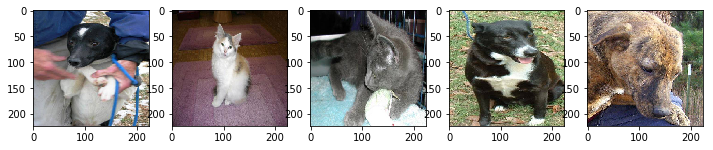

In [19]:
f = plt.figure(figsize=(12,6))
for i, x in enumerate(images[:5]):
    f.add_subplot(1, 5, i + 1)
    plt.imshow(Image.open(x).resize((224,224)))

In [20]:
def run_test(model, loader):#用来对test数据集进行predict的函数
    preds = []
    model.eval()
    start_time = time.time()
    for x, _ in loader:
        with torch.no_grad():
            x_var = x.cuda()
            scores = model(x_var)
            preds.append(scores)
    print('duration = %s\n' % timedelta(seconds=time.time() - start_time))
    return preds

In [21]:
preds = run_test(model, test_loader)

duration = 0:06:03.932760



In [22]:
preds[0].shape

torch.Size([32, 2])

In [23]:
pred_soft = F.softmax(torch.cat(preds), dim=1).cpu().numpy()

In [24]:
pred_soft

array([[1.8510987e-03, 9.9814892e-01],
       [9.9999762e-01, 2.3630253e-06],
       [9.9961567e-01, 3.8431681e-04],
       ...,
       [8.2114850e-05, 9.9991786e-01],
       [3.8817484e-06, 9.9999607e-01],
       [2.0733023e-02, 9.7926700e-01]], dtype=float32)

In [28]:
pred_soft.shape

(75000, 2)

In [25]:
pred_result = pred_soft[:, 1]

In [26]:
pred_result.shape

(75000,)

In [27]:
# 什么是finetune,怎么finetune?
# 提交gz文件

# 加和 average/max 
# 多个网络提feature，然后再加两层或一层全连接

## trick